# COGS 108 - Final Project 

# Overview

For this assignment, I use Yelp data along with health inspection data for restaurants in North Carolina to determine how Yelp price tiers and health inspection scores relate to aggregate Yelp star ratings. In my analysis, I discovered that pricing tiers are a more important determinant in a restaurant's Yelp aggregate review score, although neither price nor health inspection account for much of the variability in review scores. For the correlations that we could observe, a more expensive pricing tier and better health inspection scores both have a slight positive correlation with increasing Yelp review scores.

# Name & GitHub ID

- Name: Aaron Oliver
- GitHub Username: AaronAOliver

# Research Question

For restaurants in North Carolina, is health inspection score or menu pricing tier a more important determinant in a restaurant's Yelp aggregate review score?

## Background and Prior Work

Yelp is a popular website where users can provide reviews for various businesses, particularly restauarants. Yelp reviews are on a scale of 1 to 5 stars, where half-star increments are also allowed. Positive Yelp reviews of businesses have been found to increase revenue, especially independent businesses that are not associated with a chain [1]. Yelp reviews are consistent across timeframes and locations [2], allowing us to compare aggregate Yelp reviews that combine star ratings from multiple years in multiple locations across North Carolina. Reviews also crowdsource an overall pricing tier for their menu, which is marked as a dollar sign (\\$) from 1 to 4 signs. \\$\\$\\$\\$ signifies the most expensive restaurants.

Previous research suggests that the text associated with individual Yelp reviews can be used to predict health code violations in San Francisco [3]. In North Carolina, food safety inspections are performed at least annually, if not multiple times per year [4]. Restaurants must recieve a grade of at least 70 to remain open, while the highest grade of "A" is reserved for inspection scores of 90 or more [4]. However, these inspection results must be considered in the context of the people that perform the reviews and the workers of these businesses. Past research has shown that inspection frequency and safety violations are associated with the demographic makeup and socioeconomic status of the surrounding area [5].


References (include links):
- 1) Reviews, Reputation, and Revenue: The Case of Yelp.Com, https://papers.ssrn.com/sol3/papers.cfm?abstract_id=1928601
- 2) Restaurant Ratings On Yelp Are Remarkably Consistent, No Matter Who’s Writing Them, When, And Where, https://blog.yelp.com/2018/09/restaurant-ratings-on-yelp-are-remarkably-consistent-no-matter-whos-writing-them-when-and-where
- 3) Supplementing Public Health Inspection via Social Media, https://journals.plos.org/plosone/article?id=10.1371/journal.pone.0152117
- 4) About the Inspection Process in Forsyth County, https://www.forsyth.cc/PublicHealth/EnvironmentalHealth/aboutInspections.aspx
- 5) Inspection Frequency, Sociodemographic Factors, and Food Safety Violations in Chain and Nonchain Restaurants, Philadelphia, Pennsylvania, 2013-2014, https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5349477/

# Hypothesis


I predict that price will be a more important determinant in a restaurant's Yelp review score than health inspection ratings. This is because customers directly interact with the prices of menu items when buying food, but may not notice the health and safety violations going on in a restaurant. Restaurants with poor health inspections scores may also try to hide these scores from customers in order to avoid a loss of business.

# Dataset(s)

- Dataset Name: yelp.csv
- Link to the dataset: https://raw.githubusercontent.com/AaronAOliver/Projects/master/Option2_Individual/yelp.csv
- Number of observations: 3,688

A comma separated collection of Yelp reviews for businesses in North Carolina. The important columns from this dataset are the addresses, the average star reviews (out of 5), and the price levels (\\$ [1], \\$\\$ [2], \\$\\$\\$ [3], or \\$\\$\\$\\$ [4]). Each observation is a specific business. We are not told where this dataset is from, but my prediction is that it comes from webscraping the Yelp website.

- Dataset Name: intspections.csv
- Link to the dataset: https://raw.githubusercontent.com/AaronAOliver/Projects/master/Option2_Individual/inspections.csv
- Number of observations: 18,466

A comma separated collection of health inspections for businesses in North Carolina. There can be multiple health inspections for the same business as observations. The important columns from this dataset are the addresses, the date of inspection, the type of facility, and the inspection score. Each observation is an individual instance of a health inspection. We are not told where this dataset is from, but my prediction is that it comes from a governmental website.

To combine these two datasets, we will first only take the most recent health inspection determined by data of inspection in inspections.csv. Then, we will standardize addresses between yelp.csv and inspections.csv, such that an observation with the same address in yelp.csv and inspections.csv will be merged into one observation.

# Setup

In [96]:
# Import Libraries
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import patsy
import statsmodels.api as stats

# Configure libraries
# The seaborn library makes plots look nicer
sns.set(rc={'figure.figsize':(11,8)})
sns.set_context('talk')
sns.set_style(style='ticks')


# Import Datasets
yelp_df = pd.read_csv("https://raw.githubusercontent.com/AaronAOliver/Projects/master/Option2_Individual/yelp.csv")
inspection_df = pd.read_csv("https://raw.githubusercontent.com/AaronAOliver/Projects/master/Option2_Individual/inspections.csv")

# Prune columns for only features of importance
yelp_df = yelp_df[['name', 'rating', 'review_count', 'address1', 'zip_code', 'price']]
inspection_df = inspection_df[['date', 'name', 'address1', 'zip', 'score', 'facilitytype']]

# Data Cleaning

Before any cleaning, we will subset the inspections dataset to only consider businesses that are listed as restaurants.

In [97]:
inspection_df = inspection_df[inspection_df['facilitytype'] == "Restaurant"]
inspection_df = inspection_df.drop(['facilitytype'], axis=1)

Now will need to clean the values of each column individually. First, we take a look at the price values of the Yelp reviews:

In [98]:
yelp_df['price'].unique()

array(['$$', '$', '$$$', nan, '$$$$', '19198407700', '18775769464',
       '19194811105', '19196150592', '19192666118', '19108685071',
       '19198469808', '19199869521', '19194660308', '19194660360',
       '19198884887', '19194607025', '19194692122', '19194899364',
       '19195827000', '19193870228', '19197843100', '19198217991',
       '19106926261', '19198217400', '19198320501', '19196000870',
       '19198824629', '19195214445', '19198484906', '19198500891',
       '19194362246', '19197793900', '19197822594', '19198344000',
       '19198213111', '19194250800', '19195526154', '19198473548'],
      dtype=object)

It appears that telephone numbers have been incorrectly entered into the price column. We will have to parse this and remove any business that is not given a price value.

In [99]:
def standardize_prices(text):
    #phone numbers and NAs
    if isinstance(text, int):
        return 0
    
    #valid prices
    text = text.strip()
    if text == "$":
        return 1
    elif text == "$$":
        return 2
    elif text == "$$$":
        return 3
    elif text == "$$$$":
        return 4
    
    #invalid prices
    else:
        return 0
    
yelp_df[['price']] = yelp_df[['price']].fillna(value=0)
yelp_df['price'] = yelp_df['price'].apply(standardize_prices) 
yelp_df = yelp_df[yelp_df['price'] > 0]

Now we can see that we only have four types of price, represented numerically:

In [100]:
yelp_df['price'].value_counts()

2    1416
1    1326
3     112
4      20
Name: price, dtype: int64

Next is to standardize the addresses between the two datasets. We will convert to lowercase and replace abbreviations with the full words.

In [101]:
def standardize_addresses(address):
    if not isinstance(address, str):
        address = str(address)
    address = address.lower().strip() + " "
    address = address.replace(" dr ", " drive ")
    address = address.replace(" rd ", " road ")
    address = address.replace(" st ", " street ")
    address = address.replace(" pkwy ", " parkway ")
    address = address.replace(" hwy ", " highway ")
    address = address.replace(" blvd ", " boulevard ")
    address = address.replace(" blv ", " boulevard ")
    address = address.replace(" ct ", " court ")
    address = address.replace(" bldg ", " building ")
    address = address.replace(" pl ", " place ")
    address = address.replace(" ave ", " avenue ")
    address = address.replace(" cir ", " circle ")
    address = address.replace(" cntr ", " center ")
    address = address.replace(" fwy ", " freeway ")
    address = address.replace(" jct ", " junction ")
    address = address.replace(" plz ", " plaza ")
    address = address.replace(" rte ", " route ")
    address = address.replace(" ln ", " lane ")
    address = address.replace(" trl ", " trail ")
    
    #fix double space entry error in some entries
    address = address.replace("  ", " ")
    
    return address.strip()
    
yelp_df['address1'] = yelp_df['address1'].apply(standardize_addresses)
inspection_df['address1'] = inspection_df['address1'].apply(standardize_addresses)

Now we look at zip codes:

In [102]:
yelp_df['zip_code'].unique()

array([27560, 27519, 27612, 27893, 27896, 28573, 27807, 27804, 27870,
       28578, 27812, 27215, 27253, 27601, 27406, 27573, 27041, 27377,
       27401, 27203, 27023, 27410, 27516, 27610, 27518, 27609, 27701,
       27587, 27513, 27709, 27603, 27607, 27606, 27529, 28304, 28540,
       28303, 28546, 28345, 27546, 27617, 27576, 27713, 27502, 27504,
       27545, 27616, 27705, 27703, 27704, 27604, 27511, 32256, 27615,
       27608, 27707, 27510, 27527, 27278, 27613, 28545, 27614, 27523,
       27539, 27597, 27542, 27540, 27526, 27450, 27302, 27605, 27722,
       27520, 27591, 27592, 27517, 27571, 27501, 28587, 27712, 27549,
       27508, 27522, 27514, 27312, 27596, 27588, 27534, 27332, 27330,
       27623, 27512, 27577, 22701, 27711, 27515])

In [103]:
inspection_df['zip'].unique()

array([27610, 27513, 27606, 27529, 27511, 27616, 27607, 27604, 27587,
       27605, 27615, 27609, 27612, 27502, 27613, 27617, 27560, 27601,
       27545, 27526, 27540, 27608, 27597, 27518, 27539, 27603, 27614,
       27519, 27571, 27562, 27520, 27591, 27628, 27592, 27695, 27523,
       27512, 27619, 27652, 27595, 27709, 27650, 27501, 27579, 28587])

Both datasets use the standard 5 digit representation zip codes, so no further work needs to be done there. Next, we combine the street address and zip code into a single string so we can join the two datasets along this column.

In [104]:
yelp_df = yelp_df.dropna(subset=['address1', "zip_code"])
yelp_df['full_address'] = yelp_df['address1'].map(str) + ", " + yelp_df['zip_code'].map(str)

inspection_df = inspection_df.dropna(subset=['address1', "zip"])
inspection_df['full_address'] = inspection_df['address1'].map(str) + ", " + inspection_df['zip'].map(str)

Before merging, we need to select the most recent health inspection for each location. To do this, we will sort by earliest date and take the last instance of a business name as we traverse down the dataframe. As a test, we will check which health inspection we keep for the Panera Bread #1643.

In [105]:
inspection_df[inspection_df['name'] == "Panera Bread #1643"]

,date,name,address1,zip,score,full_address
3,2012-09-21T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,99.0,"1065 darrington drive, 27513"
1732,2013-03-13T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,96.0,"1065 darrington drive, 27513"
5057,2014-01-15T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,97.5,"1065 darrington drive, 27513"
7141,2014-07-30T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,96.5,"1065 darrington drive, 27513"
10727,2015-05-01T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,95.5,"1065 darrington drive, 27513"
10728,2015-05-01T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,95.5,"1065 darrington drive, 27513"
14356,2016-01-19T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,95.5,"1065 darrington drive, 27513"
17271,2016-08-09T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,95.0,"1065 darrington drive, 27513"


The latest Panera Bread #1643 inspection occurs on 2016-08-09.

In [106]:
inspection_df = inspection_df.sort_values(["date"]).drop_duplicates(subset=['name'], keep='last')
inspection_df[inspection_df['name'] == "Panera Bread #1643"]

,date,name,address1,zip,score,full_address
17271,2016-08-09T00:00:00Z,Panera Bread #1643,1065 darrington drive,27513,95.0,"1065 darrington drive, 27513"


And this is the inspection that we keep! So we have successfully maintained only the most recent inspection for each establishment. Finally, we join together the two datasets based on address. A quick scan of the business names from yelp and the health inspection show mostly matches between the names, although some differences can arise from business closures, multiple businesses with the same address, and company rebranding. This is one limitation of our analysis and our dataset, which I will discuss further in later sections.

In [107]:
combined_df = pd.merge(yelp_df, inspection_df, how='inner', on='full_address')
combined_df.head()

,name_x,rating,review_count,address1_x,zip_code,price,full_address,date,name_y,address1_y,zip,score
0,holiday inn express & suites raleigh ne - medi...,3.0,7,3618 new bern avenue,27610,2,"3618 new bern avenue, 27610",2016-08-05T00:00:00Z,HOLIDAY INN EXPRESS BREAKFAST,3618 new bern avenue,27610,95.0
1,desi mazaa,4.0,4,212 grande heights drive,27513,2,"212 grande heights drive, 27513",2016-06-24T00:00:00Z,DESI MAZAA,212 grande heights drive,27513,90.0
2,insomnia cookies,3.5,43,2302 hillsborough street,27607,1,"2302 hillsborough street, 27607",2016-03-10T00:00:00Z,BRUEGGERS BAGELS #18,2302 hillsborough street,27607,97.0
3,bruegger's bagels,3.0,16,2302 hillsborough street,27607,1,"2302 hillsborough street, 27607",2016-03-10T00:00:00Z,BRUEGGERS BAGELS #18,2302 hillsborough street,27607,97.0
4,hawthorn suites by wyndham raleigh,3.5,11,1020 buck jones road,27606,2,"1020 buck jones road, 27606",2016-06-10T00:00:00Z,HAWTHORN SUITES BREAKFAST,1020 buck jones road,27606,96.0


Since health inspections can take place in multiple areas within one business, we will only take a unique instance of each yelp review. Then, we prune the columns to remove repetitive data. Now we have generated a dataset that we can perform exploratory data analysis on.

In [108]:
# Our final dataset
combined_df = combined_df.sort_values(["address1_x"]).drop_duplicates(subset=["address1_x"], keep='first')
combined_df = combined_df[['name_y', 'full_address', 'rating', 'review_count', 'price', 'score']]
renames = {'price':'yelp_price','name_y': 'restaurant', 'full_address': 'address', 'score': 'health_score', 'rating':'yelp_rating', 'review_count':'yelp_reviews'}
df = combined_df.rename(columns=renames).reset_index(drop=True)
df['restaurant'] = df['restaurant'].str.lower()
df

,restaurant,address,yelp_rating,yelp_reviews,yelp_price,health_score
0,east village bar & grill,"1 dixie trail, 27607",3.0,42,2,93.0
1,groucho's deli,"10 horne street, 27607",4.0,25,1,98.0
2,j. betski`s,"10 w franklin street, 27604",4.5,247,2,96.5
3,dim sum house,"100 jerusalem drive, 27560",3.0,228,2,94.0
4,goji bistro,"100 maynard crossing court, 27513",4.5,81,2,93.0
...,...,...,...,...,...,...
983,la taqueria,"973 e broad street, 27526",4.0,14,1,95.5
984,ledo pizza,"982 high house road, 27513",4.0,35,2,91.5
985,fiesta mexicana,"990 high house road, 27513",4.0,25,1,92.5
986,zaxby's #46101,"995 durham road, 27587",3.5,4,1,97.0


# Data Analysis & Results

Our first step will be to look at the descriptive statistics for our variables. Note that the Yelp price and health inspection score variables are not continuous numeric variables, but ordinal variables. The possible values for the Yelp prices are 1, 2, 3, or 4, corresponding to the \\$, \\$\\$, \\$\\$\\$, and \\$\\$\\$\\$ categories of overall menu price as determined by Yelp. Health inspection scores scores can take on values in range between 0 and 100 in 0.5 increments, although the minimum health score in our dataset is above 70. The possible values for individual Yelp ratings are 1, 1.5, 2, ..., 4.5, or 5 stars, and the aggregate rating for a restaurant is rounded to the closest of these intervals. 

The mean overall rating for a restaurant in our dataset on Yelp is almost exactly 3.5, consistent with what we could expect using background familiarity with other online rating systems. Most restaurants in our dataset have cheap prices, with an average price rating of 1.58, which is in between a \\$ and a \\$\\$ classification.

In [109]:
df.describe()

,yelp_rating,yelp_reviews,yelp_price,health_score
count,988.000000,988.000000,988.000000,988.000000
mean,3.492915,60.616397,1.588057,95.380567
std,0.735171,101.044703,0.572362,2.963114
min,1.000000,1.000000,1.000000,72.500000
25%,3.000000,12.000000,1.000000,94.000000
50%,3.500000,29.000000,2.000000,96.000000
75%,4.000000,72.000000,2.000000,97.500000
max,5.000000,1799.000000,4.000000,100.000000


For our first visualization, we examine the distribution of health inspection scores for the restaurants in our dataset. 

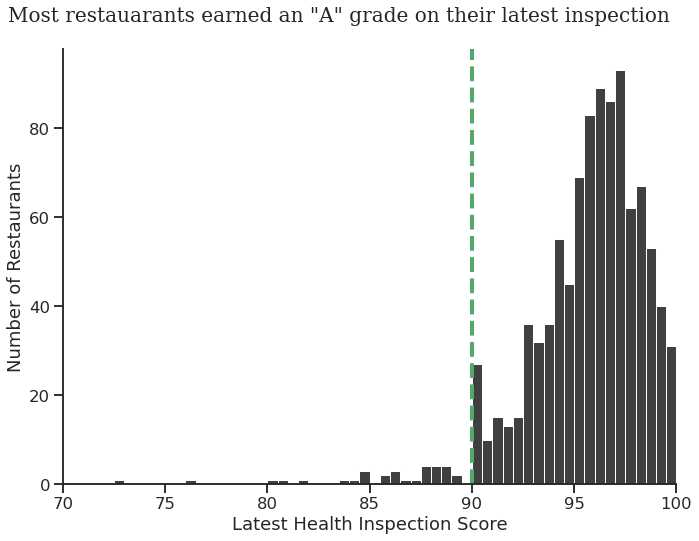

In [110]:
ax = sns.histplot(data = df['health_score'], binwidth = 0.5, color = 'black')
sns.despine()
ax.set(xlabel='Latest Health Inspection Score', ylabel='Number of Restaurants')
plt.title("Most restauarants earned an \"A\" grade on their latest inspection", x = 0.45, y = 1.05, fontsize = 20, fontname='serif')
plt.ylim(0, None)
plt.xlim(70, 100)
plt.plot([90, 90], [0, 100], 'g--', linewidth=4)
plt.show()

#### Figure 1. The histogram illustrates that the vast majority of the restauarants earned a score above 90, shown as a vertical green line, which is the treshold for an "A" grade. Note the relatively high amount of restaurants recieving a grade of exactly 90, possibly demonstrating an unwillingness of inspectors to give out less than the highest grade. The distribution is strongly right skewed near the maximum health inspection score of 100, with some low outliers in the mid 70s.

Next, we want to see if there is a relationship between the number of Yelp reviews and the average Yelp review score for a restaurant. We will visualize this with a scatterplot plotting these two variables.

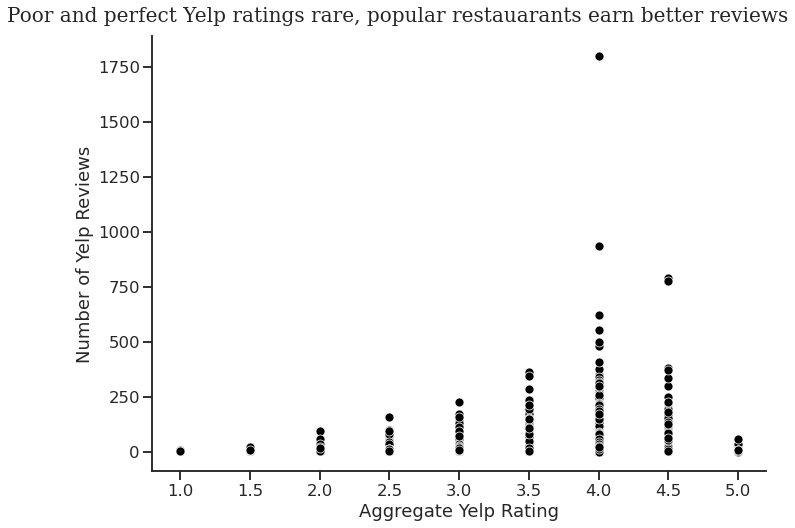

In [111]:
ax = sns.scatterplot(data = df, x = "yelp_rating", y = "yelp_reviews", color = 'black')
sns.despine()
ax.set(xlabel='Aggregate Yelp Rating', ylabel='Number of Yelp Reviews')
plt.title("Poor and perfect Yelp ratings rare, popular restauarants earn better reviews", x = 0.4, y = 1.02, fontsize = 20, fontname='serif')
plt.show()

#### Figure 2.  A scatterplot of the relationship between aggregate yelp rating and the number of reviews. We can see that the reviews are slightly right skewed, with the distribution centering around 4.0 (which prior research in our background section described as an "average" rating), and a gentle slope to the left towards restauarants with poor reviews. There are a few outliers with 4.0 and 4.5 aggregate ratings that have far more reviews than the other restaurants.

We can examine the outliers in this graph to try to determine why these restaurants have so many more ratings than the others. A brief look at the zipcodes in the addresses, 27601 and 27609, both correspond to parts of Raleigh, the largest city and capital of North Carolina. This high population in the surrounding area explains, in part, why these restaurants have so many reviews. The medium price of each of these restauarants, likely meaning more accessibility, could also help explain why there are so many reviews for these establishments.

In [112]:
df[df['yelp_reviews'] > 750]

,restaurant,address,yelp_rating,yelp_reviews,yelp_price,health_score
388,bida manda,"222 s blount street, 27601",4.5,788,2,97.0
408,beasley's/chuck's/fox,"237 s wilmington street, 27601",4.0,938,2,95.0
531,the pit,"328 w davie street, 27601",4.0,1799,2,95.5
667,the yard house #41,"4208 six forks road, 27609",4.5,776,2,95.5


Before performing a regression, we should further explore this pricing effect to see if restaurants with different pricing categories have different distributions of aggregate ratings. Once plotting issue is that all three of the restauarants with a \\$\\$\\$\\$ rating all have 3.5 stars, and so these restuarants cannot be ploted using a kernel density plot. So, we will filter those restaurants out for this next visualization.

In [113]:
df[df['yelp_price'] == 4]

,restaurant,address,yelp_rating,yelp_reviews,yelp_price,health_score
57,death and taxes,"105 w hargett street, 27601",3.5,115,4,96.5
617,chick-fil-a #00585,"400 fayetteville street, 27601",3.5,2,4,96.5
682,ruth`s chris,"4381 lassiter at north hills avenue, 27609",3.5,81,4,97.5


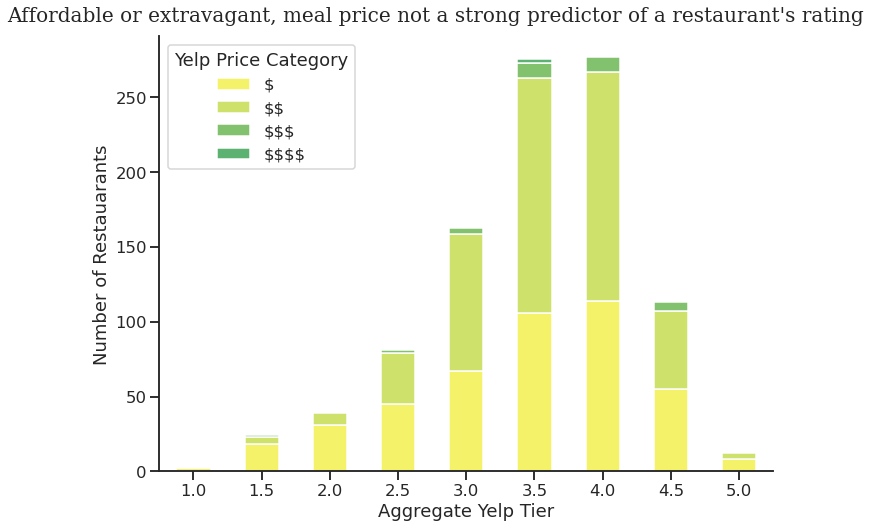

In [120]:
def price_to_dollars(price):
    if price == 1:
        return "$"
    elif price == 2:
        return '$$'
    elif price == 3:
        return '$$$'
    else:
        return '$$$$'
    
df['yelp_price_str'] = df['yelp_price'].apply(price_to_dollars)

df_plot = df.groupby(['yelp_price_str', 'yelp_rating']).size().reset_index().pivot(columns='yelp_price_str', index='yelp_rating', values=0)
ax = df_plot.plot(kind='bar', stacked=True, legend = False, color=("#F4F269", "#CEE26B", "#82C26E", "#5CB270"), rot = 0)
ax.legend(['\$', '\$\$', '\$\$\$', '\$\$\$\$'], title = "Yelp Price Category")
ax.set(xlabel = 'Aggregate Yelp Tier', ylabel = 'Number of Restauarants')
sns.despine()
plt.title("Affordable or extravagant, meal price not a strong predictor of a restaurant's rating", x = 0.45, y = 1.02, fontsize = 20, fontname='serif')
plt.show()

#### Figure 3. A stacked bar plot showing the number of inexpensive (\\$), moderately priced (\\$\\$), expensive (\\$\\$\\$\\$), and very expensive (\\$\\$\\$\\$) restaurants in North Carolina by Yelp rating. The more expensive restaurants in \\$\\$\\$ and \\$\\$\\$\\$ exist primarily in the 3.0 - 4.5 range of ratings, while \\$ and \\$\\$ constitute more of the lower rated establishments below 3.0 and the highest rated restaurants, at 5.0.  Most restauarants in our dataset are either inexpensive or moderately priced.

Now that we have performed some exploratory data analysis, we need to answer our original question about the importance of the power of Yelp price tiers and health inspection scores in influencing Yelp reviews. As an initial check, we analyze the correlation matrix of our variables. Since no correlation between different variables is close to 1 or -1, we can proceed with some confidence that we are not introducing multicollinearity.

In [115]:
df.corr()

,yelp_rating,yelp_reviews,yelp_price,health_score
yelp_rating,1.000000,0.225695,0.106224,0.071818
yelp_reviews,0.225695,1.000000,0.211605,-0.020370
yelp_price,0.106224,0.211605,1.000000,-0.016195
health_score,0.071818,-0.020370,-0.016195,1.000000


Finally, we seek to build some linear regression models to determine if the yelp price category or health inspection score is a stronger predictor of Yelp rating. From the ordinary least squares regression below, we can see that both Yelp price and health inspection score have some predictive power, as both variables procude a P-value below 0.5 (0.001 and 0.02, respectively). Unfortunately, an error signifying possible multicollinearity also appears. This is another limitation of this study that will be discussed further. Viewing the coefficient column, we can conclude that a change in Yelp price is related to a greater than in review score than a change in the health inspection score.  

In [116]:
# Generate a linear regression
outcome, predictors = patsy.dmatrices('yelp_rating ~ yelp_price + health_score', df)
mod = stats.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            yelp_rating   R-squared:                       0.017
Model:                            OLS   Adj. R-squared:                  0.015
Method:                 Least Squares   F-statistic:                     8.361
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           0.000251
Time:                        12:15:49   Log-Likelihood:                -1089.1
No. Observations:                 988   AIC:                             2184.
Df Residuals:                     985   BIC:                             2199.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        1.5331      0.752      2.039   

Since the possible increments of change in the health score are much smaller than the change in restaurant price, we convert the health score to ordinal categories corresponding to the possible health grades for a restaurant. Then, we perform the regression again using price ratings and health letter grades. Our conclusion remains unchanged however, an increase the Yelp price marking (and thus overall meal price) is related a stronger increase in overall Yelp review score than an improvement in the overall health and sanitation grade. However, with an adjusted R-squared of less than 0.02, the neither the price nor the health inspection score explain much of the variation in Yelp review score.

In [117]:
# Generate a linear regression
def health_score_to_grade(score):
    if score < 70:
        return 70 # failing grade
    elif score < 80:
        return 80 # grade of C
    elif score < 90:
        return 90 # grade of B
    else:
        return 100 # grade of A
    
df['health_grade'] = df['health_score'].apply(health_score_to_grade)
outcome, predictors = patsy.dmatrices('yelp_rating ~ yelp_price + health_grade', df)
mod = stats.OLS(outcome, predictors)
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:            yelp_rating   R-squared:                       0.016
Model:                            OLS   Adj. R-squared:                  0.014
Method:                 Least Squares   F-statistic:                     8.100
Date:                Wed, 16 Dec 2020   Prob (F-statistic):           0.000324
Time:                        12:15:49   Log-Likelihood:                -1089.4
No. Observations:                 988   AIC:                             2185.
Df Residuals:                     985   BIC:                             2199.
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                   coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.5738      1.222      0.469   

# Ethics & Privacy

We must keep in mind that this data is all generated by individuals with their own biases - health inspectors can choose to provide leniency as they see fit (as we saw in the histogram), so the inspection scores are not purely subjective. Similarly, yelp review scores are provided by individiuals, so rating summarize the tastes and opinions for single persons. Even though we use aggregate individual scores into collective data points, these results should not be seen as perfect or objective, as the data is produced by us as humans, imperfect and subjective people.

For this analysis, I am confident that I have the permission to use the dataset as it was provided by Dr. Ellis for this project. The dataset appears to use publicly available government inspection data as well as results from interactions with the Yelp API. To hide the identity of individual health inspectors, we have removed names and other identifiable from the dataset. Names of Yelp reviews are also not included in the dataset for the sake of privacy. We keep restaurant names in the dataset as of now to allow case studies of individual locations, but we will be receptive if any business asks to be removed from the dataset, and we will then rerun all analyses using the new dataset without that restaurant.

# Conclusion & Discussion

In this project, we have analyses the interactions between Yelp reviews, Yelp price tiers, and health inspection scores. We used two datasets, one of Yelp reviews and one of North Carolina health inspections. To start, we standardized addresses between the two datasets so that we could combine Yelp star ratings and health inspection scores for the same businesses. We then cleaned and standardized pricing data to fix improper data entry, and used only the most recent health inspection for each restaurant. Then, we performed exploratory data analysis to view the distributions and interactions of our different measured variables. Finally, we used an ordinary least squares regression to determine that menu pricing tier is a more important determinant for Yelp aggregate review score than either a health inspection score or health inspection grade.

This project has numerous limitations, both due to time constrains as well as data constraints. One limitation is that health inspection scores to not vary much outside of the highest grade of "A". Since most restaurants are given an A rating, and most customers can only see the categorical letter grade rating rather than the numerical score, there does not seem to be a reason why customers would have preference for one restauarant over another based on small differences in health scores. Another limitation is the use of a linear regression model, when it may not have been the best fit of the non-continuous data. Since Yelp reviews are rounded to the nearest half-star for reporting, we lose the ability to differentiate ratings along a continous scale rather than a discrete, ordinal one. This research is important in determining how restaurants can influence customers to leave positive Yelp reviews, which is an import method of advertising and reputation-building for companies. Additional text data from Yelp would allow us to detect direct references to health and safety violations, following a similar data analysis to reference [3] studying the interaction of social media and health inspections. Further exploration of this topic, given more time, could explore the interactions Yelp reviews and health inspections from this new angle.

#### Thanks to all the COGS 108 instructional staff for a great COVID quarter!